In [1]:
%load_ext lab_black

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pysal.model import mgwr
from scipy.stats import pearsonr
from sklearn.preprocessing import PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from urbana.models.plot_predictions import PredictedAccuracy
from urbana.constants import DIR_REPO, DIR_DATA

/home/ernest/anaconda3/envs/urbana/lib/python3.9/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [4]:
# papermill parameters cell
# https://papermill.readthedocs.io/en/latest/usage-parameterize.html

OUTPUT_WARNINGS = False
VARIABLE_TO_PREDICT = "Airbnb_Number"

In [5]:
sect = gpd.read_file(
    DIR_DATA / "interim/sections_geo.json",
)

sect.set_index("Tag", inplace=True)

sect.drop(
    ["N_district", "N_neighbourhood", "N_section"],
    axis=1,
    inplace=True,
)
sect.drop(["Percentage_Age_25_39"], axis=1, inplace=True)  # Duplicate


# sect.dropna(inplace=True)
sect.isnull().sum(axis=0).sort_values(ascending=False).head(10)

Airbnb_Location_Score     89
Airbnb_Price_Person       55
Airbnb_Price              55
Rent_Area_Flats           19
Rent_Price_Total_Flats    19
Rent_Price_Meter_Flats    19
Rent_Number_Flats         10
Nationality_Colombia       0
Nationality_Argentina      0
Nationality_Venezuela      0
dtype: int64

Region with maximum value : 02_077


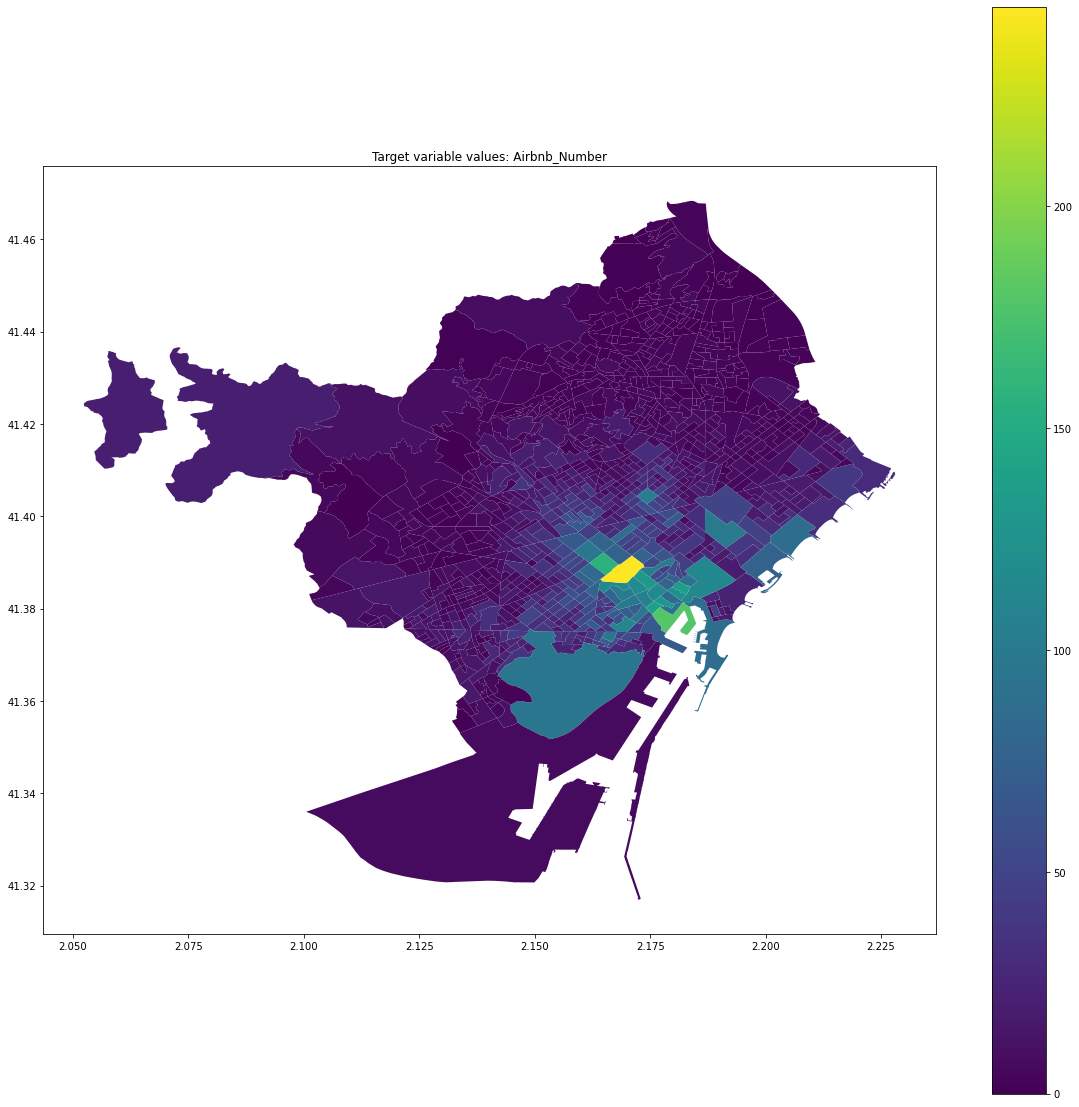

In [6]:
sect.plot(column=VARIABLE_TO_PREDICT, legend=True, figsize=(20, 20))
id_max_airbnb = sect["Airbnb_Number"].idxmax()
plt.title("Target variable values: {}".format(VARIABLE_TO_PREDICT))
print("Region with maximum value : " + str(id_max_airbnb))

In [7]:
y = np.array(sect[VARIABLE_TO_PREDICT]).reshape((-1, 1))
X = sect.drop(
    [
        "Airbnb_Number",
        "Airbnb_Price",
        "Airbnb_Price_Person",
        "Airbnb_Location_Score",
        "geometry",
    ],
    axis=1,
)
coords = np.column_stack([sect["geometry"].centroid.x, sect["geometry"].centroid.y])

geo_info = sect[["geometry"]]
geo_info["centroid"] = geo_info["geometry"].centroid

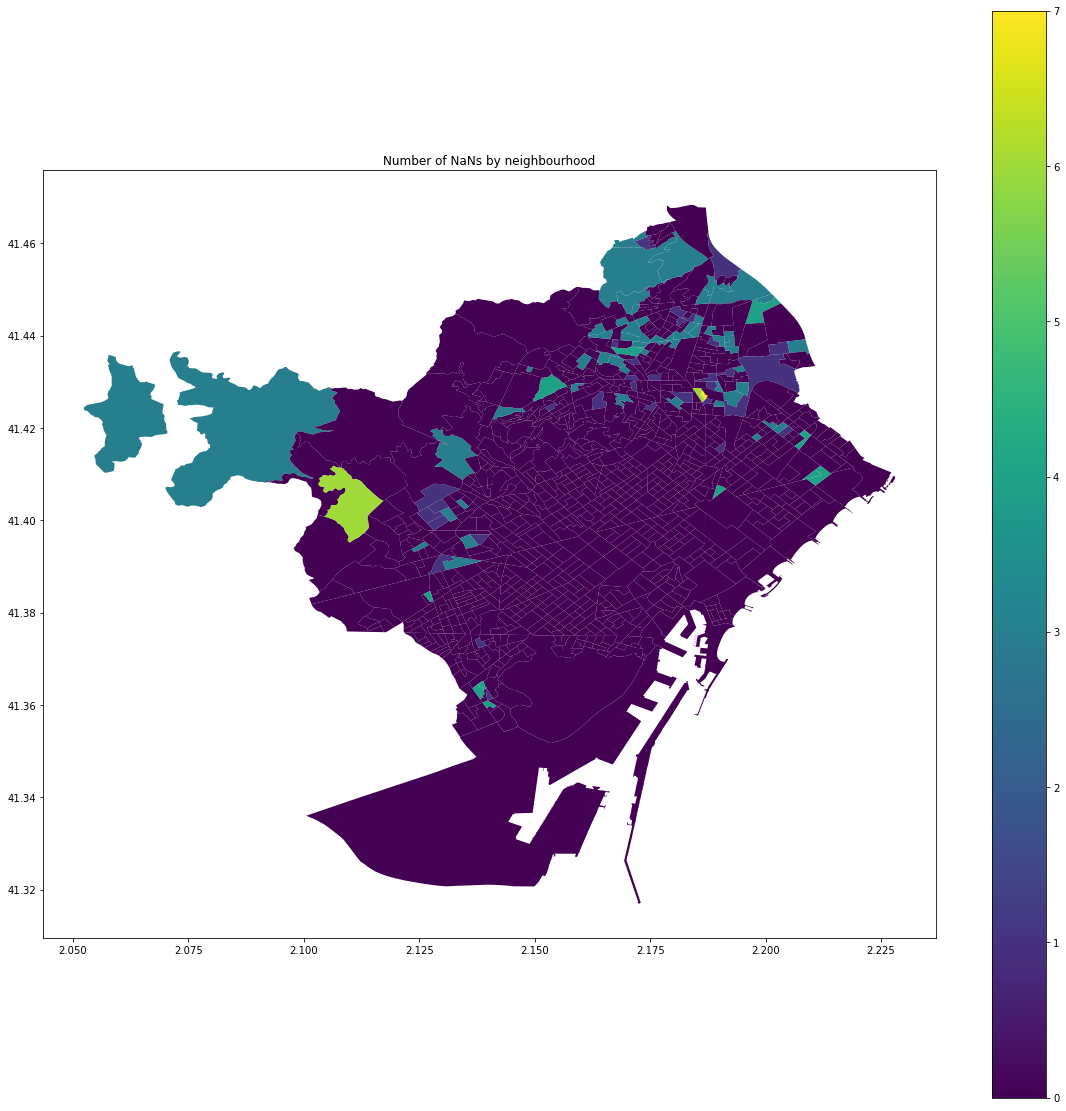

In [8]:
geo_nans = sect[["geometry"]]
geo_nans["NaNs"] = pd.isnull(sect).sum(axis=1)
geo_nans.plot(column="NaNs", legend=True, figsize=(20, 20))
plt.title("Number of NaNs by neighbourhood")
plt.show()

In [9]:
X_num = np.array(X)

# We will input the missing values with an iterative imputer
imputer = IterativeImputer()
imputer.fit(X_num)
X_num = imputer.transform(X_num)

X_std = (X_num - X_num.mean(axis=0)) / X_num.std(axis=0)
y_std = (y - y.mean(axis=0)) / y.std(axis=0)

/home/ernest/anaconda3/envs/urbana/lib/python3.9/site-packages/sklearn/impute/_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


# GWR with all the features
All of the processes being modeled operate at the same spatial scale

# GWR with chosen and transformed


We first load the best model

In [10]:
with open("linear_best.txt") as f:
    best_model = f.read().splitlines()
X_chosen = sect[best_model]
y_chosen = np.array(sect[VARIABLE_TO_PREDICT]).reshape((-1, 1))
print(best_model)

['Distance_Center', 'Nationality_UK', 'Nationality_Spain', 'POI_Restaurants_Hotels', 'Nationality_Italy', 'Percentage_Age_65_Plus', 'POI_Education', 'Education_University', 'Percentage_Age_0_14', 'Nationality_France']


Let's check if there are missing values for these features

In [11]:
pd.isnull(X_chosen).sum(0)

Distance_Center           0
Nationality_UK            0
Nationality_Spain         0
POI_Restaurants_Hotels    0
Nationality_Italy         0
Percentage_Age_65_Plus    0
POI_Education             0
Education_University      0
Percentage_Age_0_14       0
Nationality_France        0
dtype: int64

Since there are not missing values, we do not have to use a imputer.

We will transform the features so they follow a Gaussain-like distribution.

In [12]:
pw_X = PowerTransformer()
pw_X.fit(X_chosen)
X_transformed = pw_X.transform(X_chosen)

pw_y = PowerTransformer()
pw_y.fit(y_chosen)
y_transformed = pw_y.transform(y_chosen)

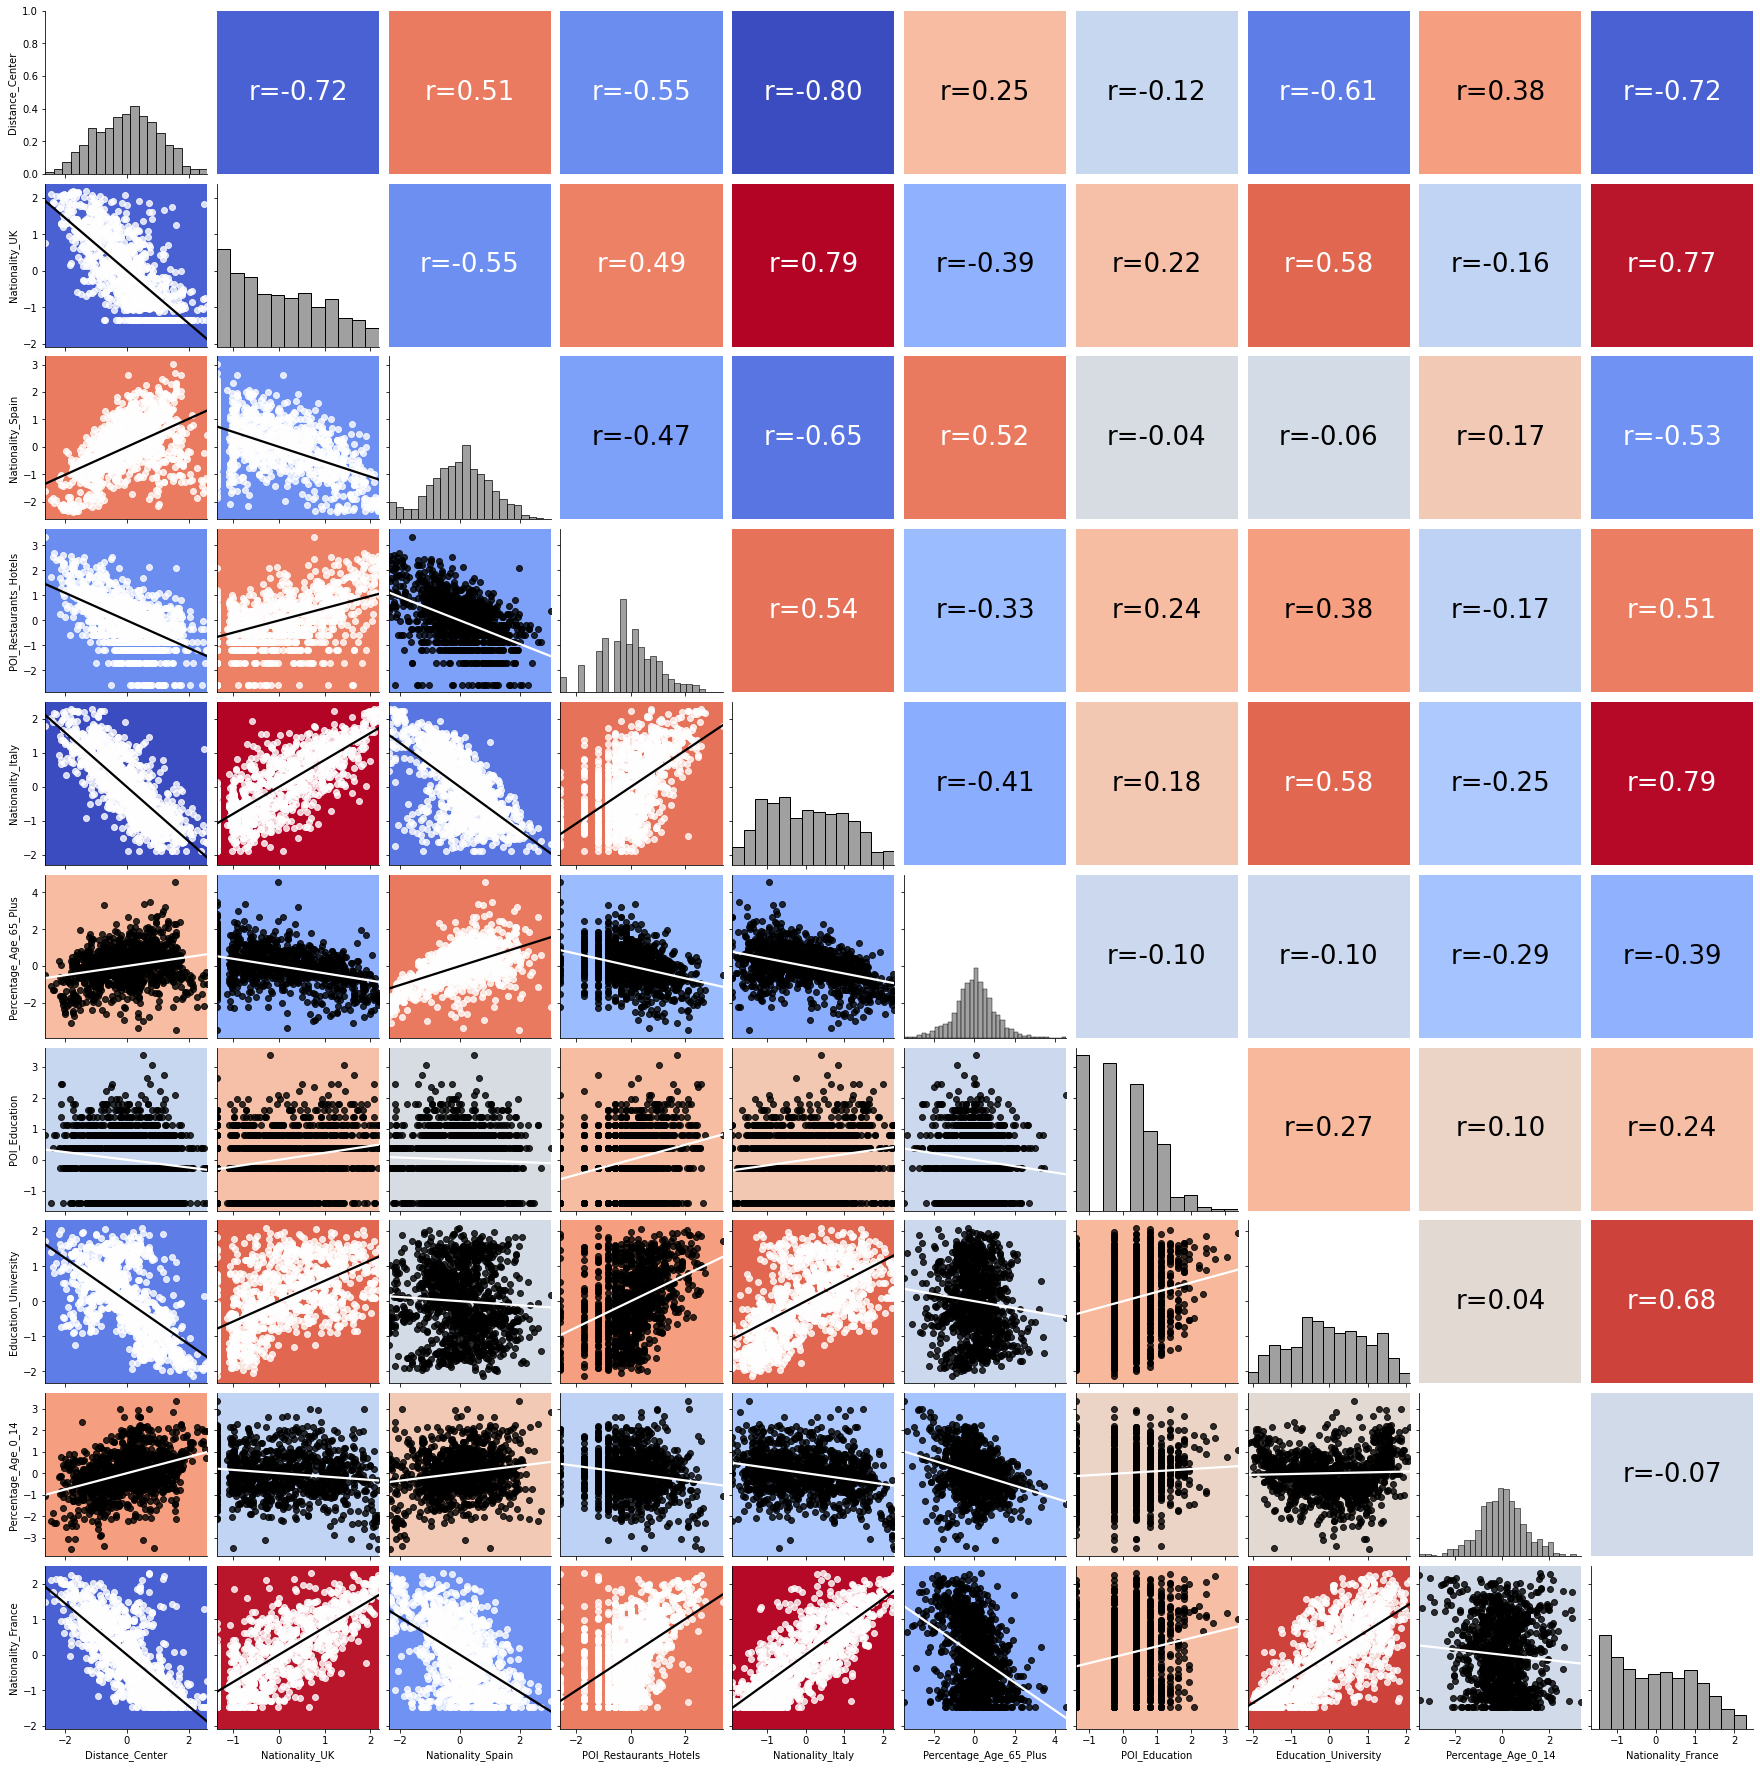

In [13]:
def corrfunc(x, y, **kwds):
    cmap = kwds["cmap"]
    norm = kwds["norm"]
    ax = plt.gca()
    ax.tick_params(bottom=False, top=False, left=False, right=False)
    sns.despine(ax=ax, bottom=True, top=True, left=True, right=True)
    r, _ = pearsonr(x, y)
    facecolor = cmap(norm(r))
    ax.set_facecolor(facecolor)
    lightness = (max(facecolor[:3]) + min(facecolor[:3])) / 2
    ax.annotate(
        f"r={r:.2f}",
        xy=(0.5, 0.5),
        xycoords=ax.transAxes,
        color="white" if lightness < 0.7 else "black",
        size=26,
        ha="center",
        va="center",
    )


def scattfunc(x, y, **kwds):
    cmap = kwds["cmap"]
    norm = kwds["norm"]
    ax = plt.gca()
    r, _ = pearsonr(x, y)
    facecolor = cmap(norm(r))
    lightness = (max(facecolor[:3]) + min(facecolor[:3])) / 2
    myColor = "white" if lightness < 0.7 else "black"
    lineColor = "black" if lightness < 0.7 else "white"
    ax.set_facecolor(facecolor)
    sns.regplot(x, y, ax=ax, color=myColor, line_kws={"color": lineColor}, ci=None)


g = sns.PairGrid(pd.DataFrame(X_transformed, columns=X_chosen.columns))
g.map_lower(
    scattfunc, cmap=plt.get_cmap("coolwarm"), norm=plt.Normalize(vmin=-0.8, vmax=0.8)
)
g.map_diag(sns.histplot, color="gray", kde=False)
g.map_upper(
    corrfunc, cmap=plt.get_cmap("coolwarm"), norm=plt.Normalize(vmin=-0.8, vmax=0.8)
)
g.fig.subplots_adjust(wspace=0.06, hspace=0.06)  # equal spacing in both directions
plt.savefig("corrs.jpg")

In [14]:
vif = pd.DataFrame()
vif["VIF"] = [
    variance_inflation_factor(X_transformed, i) for i in range(X_transformed.shape[1])
]
vif["variable"] = X_chosen.columns

vif

VIF                variable
0  4.182692         Distance_Center
1  3.396445          Nationality_UK
2  3.028326       Nationality_Spain
3  1.696636  POI_Restaurants_Hotels
4  5.274935       Nationality_Italy
5  1.931485  Percentage_Age_65_Plus
6  1.153936           POI_Education
7  3.655300    Education_University
8  1.881934     Percentage_Age_0_14
9  4.161769      Nationality_France

Now select the best k for the nearest neighbours bandwith.

In [15]:
gwr_chosen_selector = mgwr.sel_bw.Sel_BW(
    coords, y_transformed, X_transformed, fixed=False, spherical=True, multi=False
)
gwr_chosen_bw = gwr_chosen_selector.search()
print("GWR with chosen and transformed features")
print("Bandwith (KNN): " + str(int(gwr_chosen_bw)))

GWR with chosen and transformed features
Bandwith (KNN): 279


Fit the model

In [16]:
gwr_chosen_model = mgwr.gwr.GWR(coords, y_transformed, X_transformed, gwr_chosen_bw)
gwr_chosen_results = gwr_chosen_model.fit()
# gwr_chosen_results.summary()

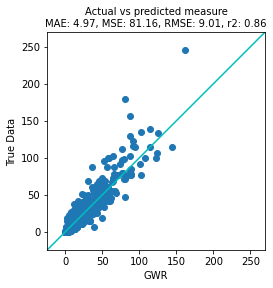

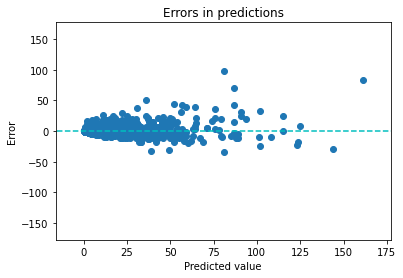

In [17]:
gwr_chosen_model.predict(coords, X_transformed)
y_predicted = gwr_chosen_results.predictions
y_predicted = pw_y.inverse_transform(y_predicted).round().flatten()
y_predicted = pd.Series(y_predicted, name="GWR")
y_truth = pd.Series(y.flatten(), name="True Data")
pa_gwr = PredictedAccuracy(y_truth, y_predicted)
pa_gwr.plot_scatter()

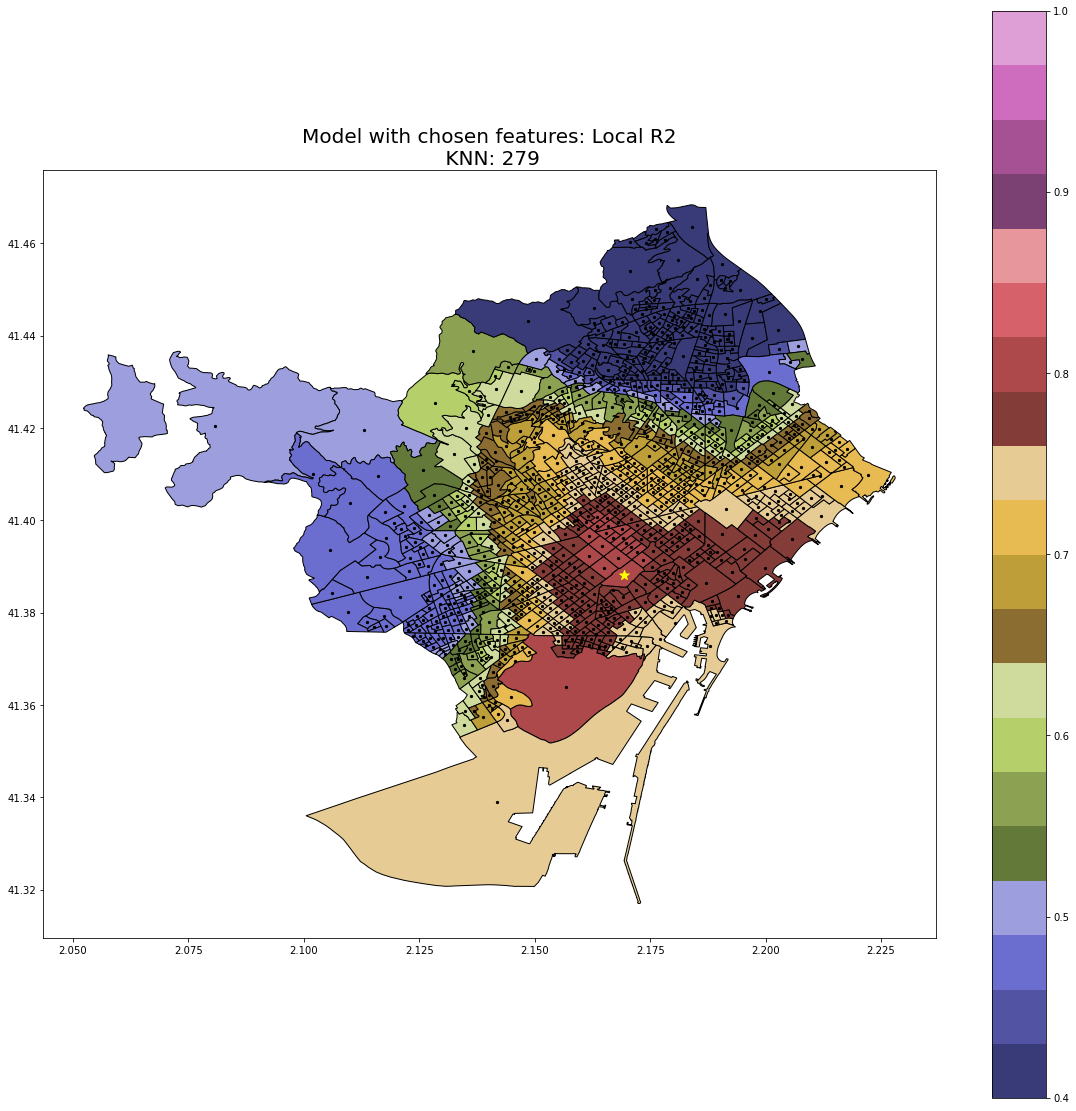

In [18]:
geo_info["Chosen_Local_R2"] = gwr_chosen_results.localR2

fig, ax = plt.subplots(figsize=(20, 20))
geo_info.plot(
    ax=ax,
    edgecolor="black",
    column="Chosen_Local_R2",
    legend=True,
    vmin=0.4,
    vmax=1,
    cmap="tab20b",
)
geo_info.centroid.plot(ax=ax, color="black", markersize=5)
sect[sect.index == id_max_airbnb].centroid.plot(
    ax=ax, marker="*", color="yellow", markersize=100
)

ax.set_title(
    "Model with chosen features: Local R2\n KNN: {}".format(int(gwr_chosen_bw)),
    fontsize=20,
)
plt.show()

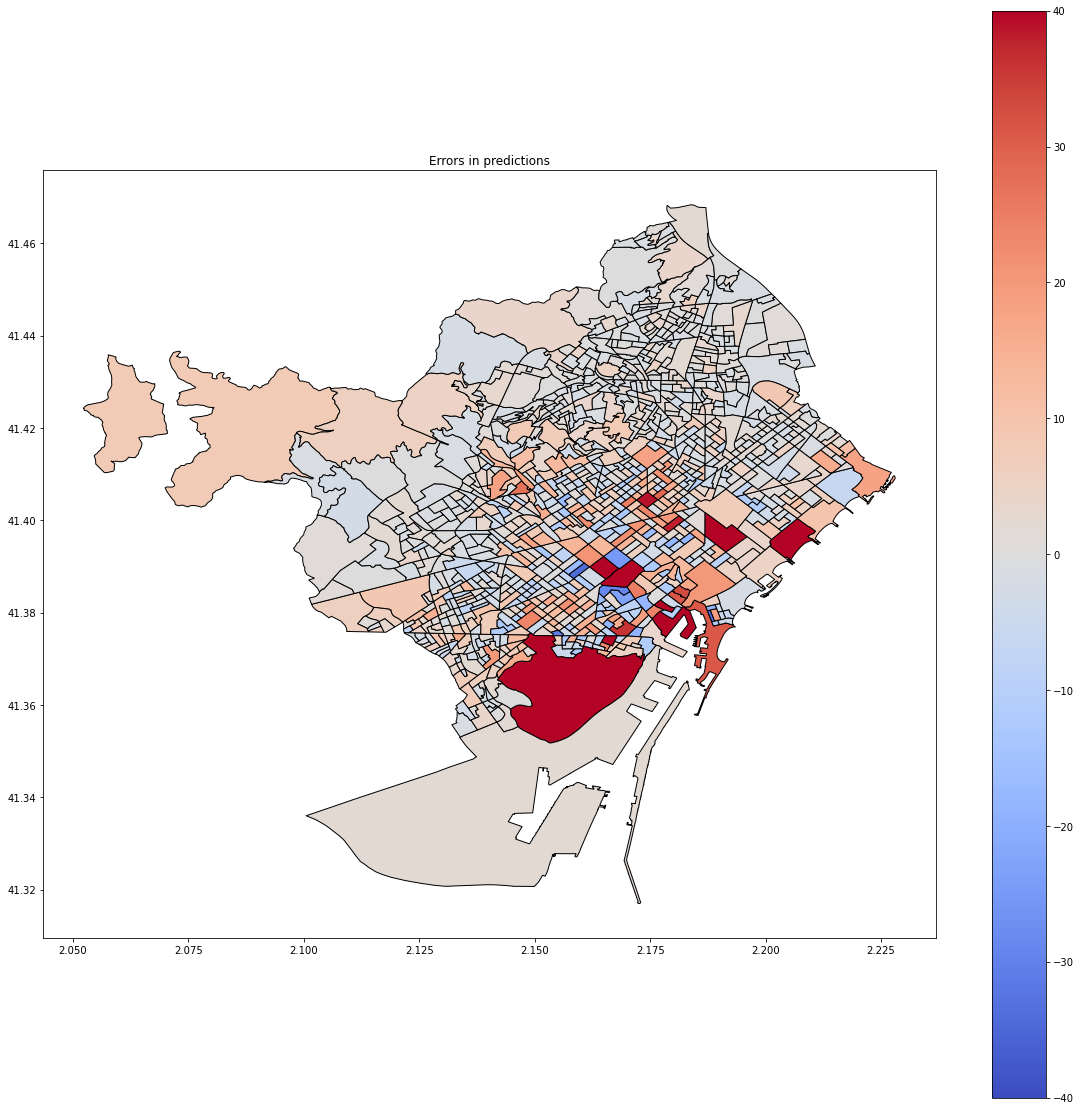

In [19]:
geo_info["Chosen_Error"] = y_truth.values - y_predicted.values
geo_info.plot(
    column="Chosen_Error",
    legend=True,
    figsize=(20, 20),
    edgecolor="black",
    cmap="coolwarm",
    vmin=-40,
    vmax=40,
)
plt.title("Errors in predictions")
plt.show()

In [20]:
chosen_gwr_columns = best_model.copy()
chosen_gwr_columns.insert(0, "Intercept")
coefs_chosen_gwr = pd.DataFrame(gwr_chosen_results.params, columns=chosen_gwr_columns)

Text(0.5, 1.0, 'GWR coefficients for each section')

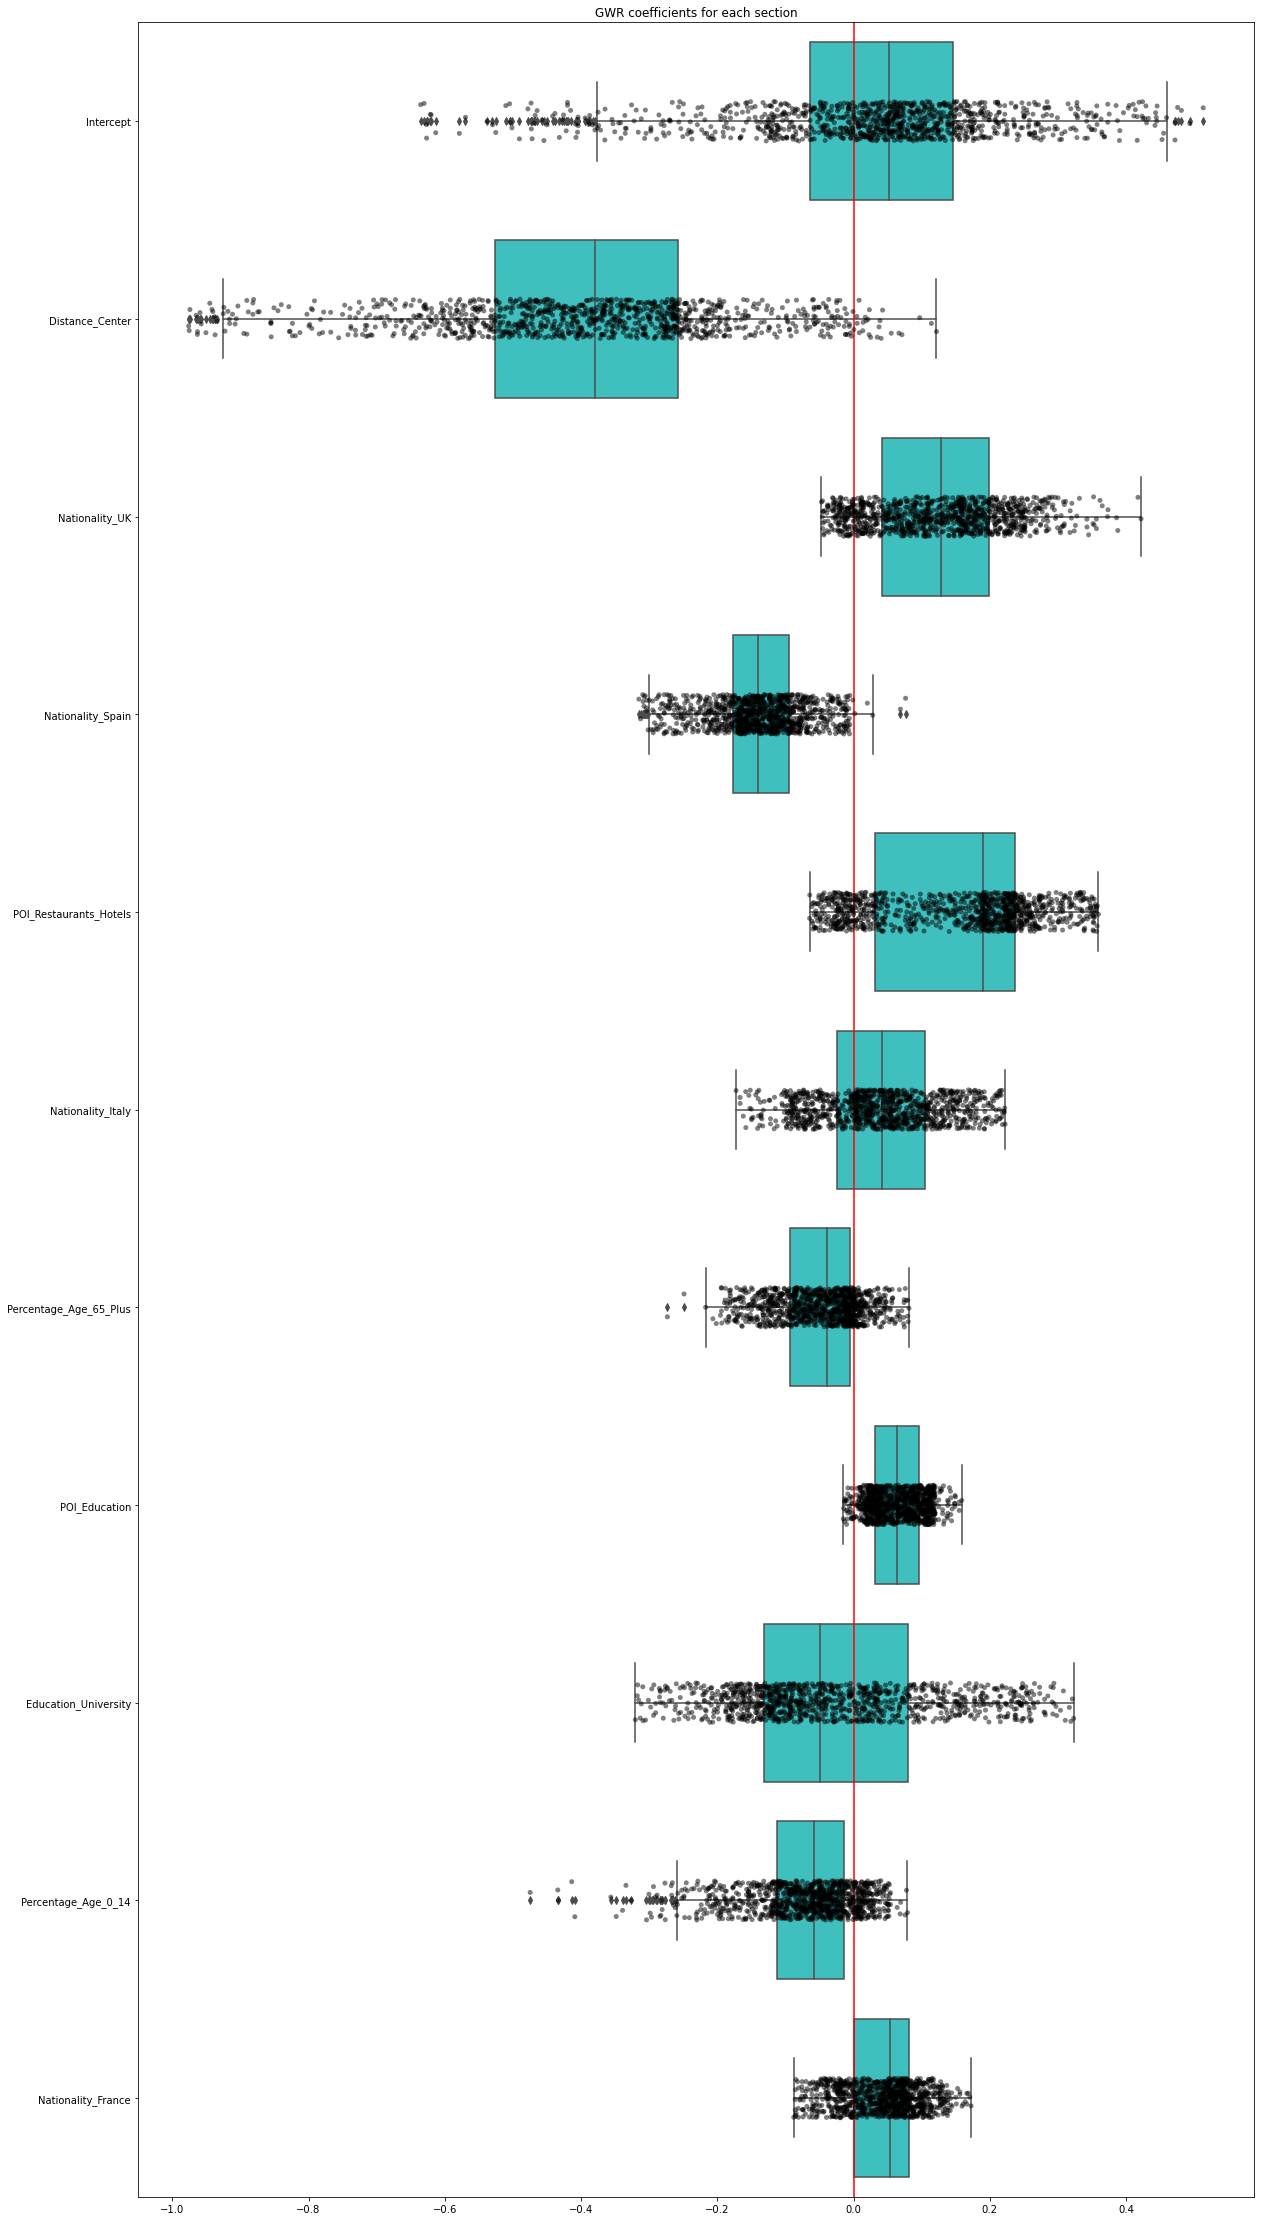

In [21]:
plt.figure(figsize=(20, 40))
sns.stripplot(data=coefs_chosen_gwr, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs_chosen_gwr, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color="red")

plt.title("GWR coefficients for each section")

# plt.savefig("gwr_coefs.jpg")

In [22]:
for col in coefs_chosen_gwr.columns:
    if col != "Intercept":
        geo_info[col] = coefs_chosen_gwr[col].values

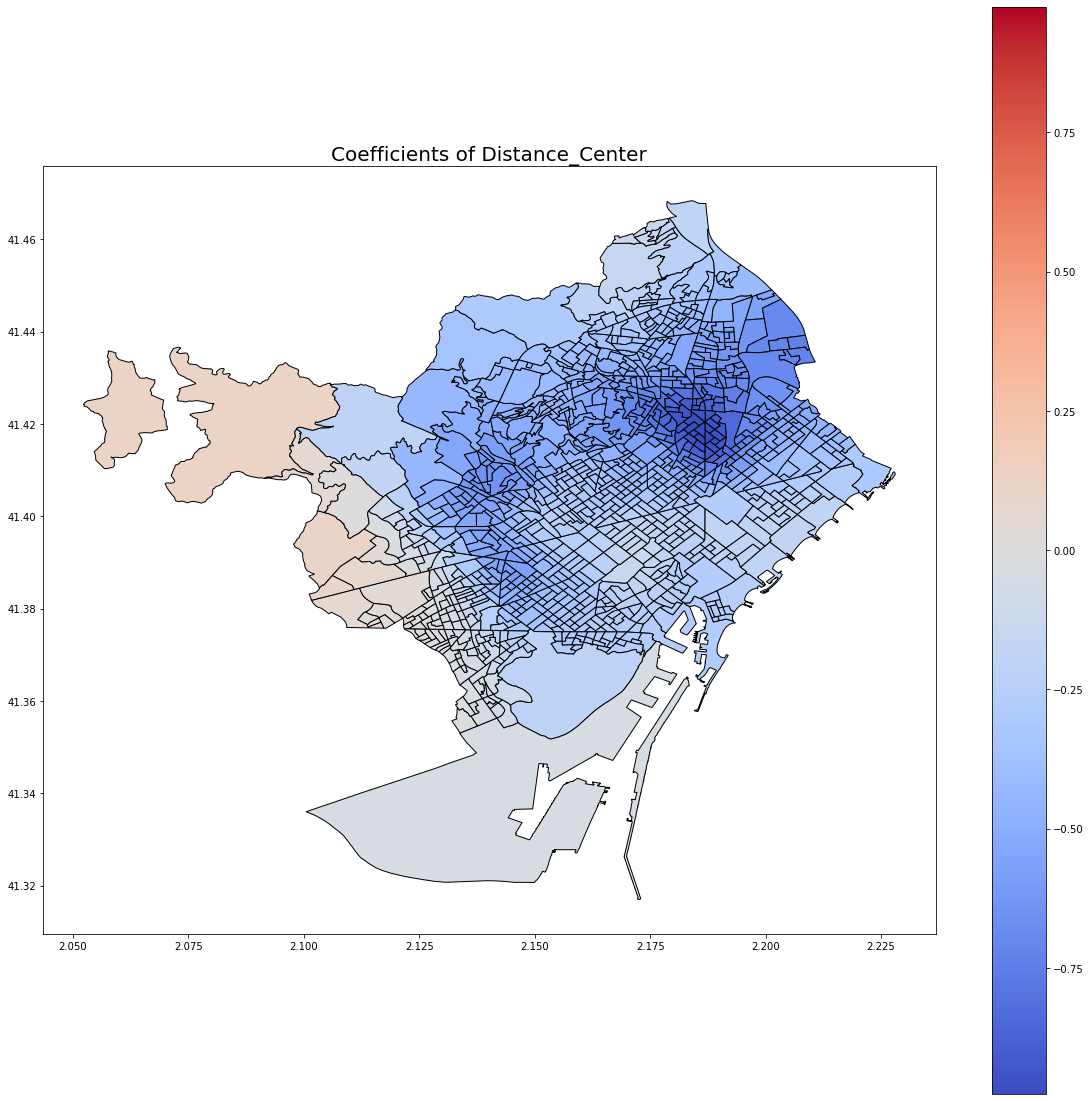

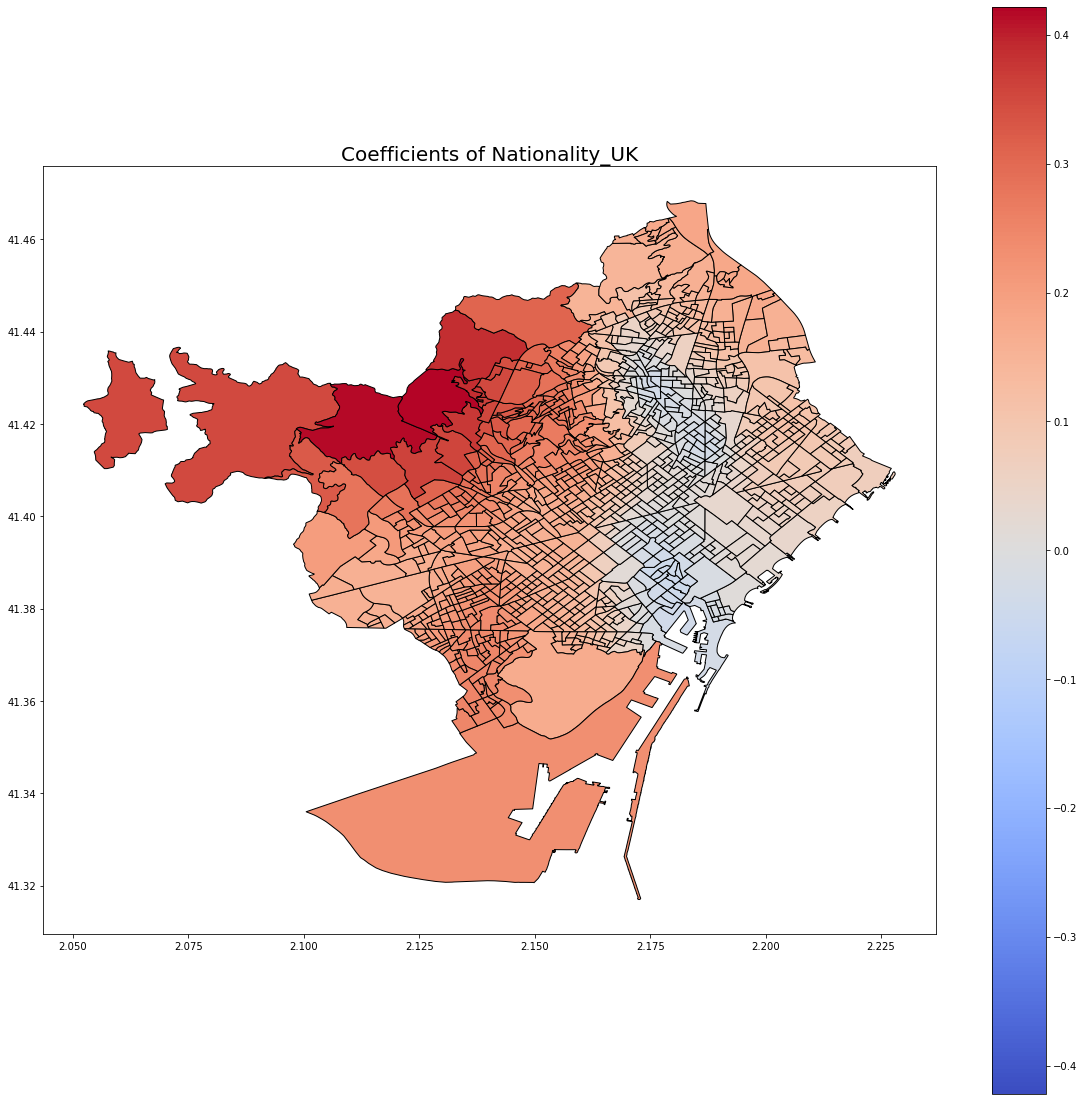

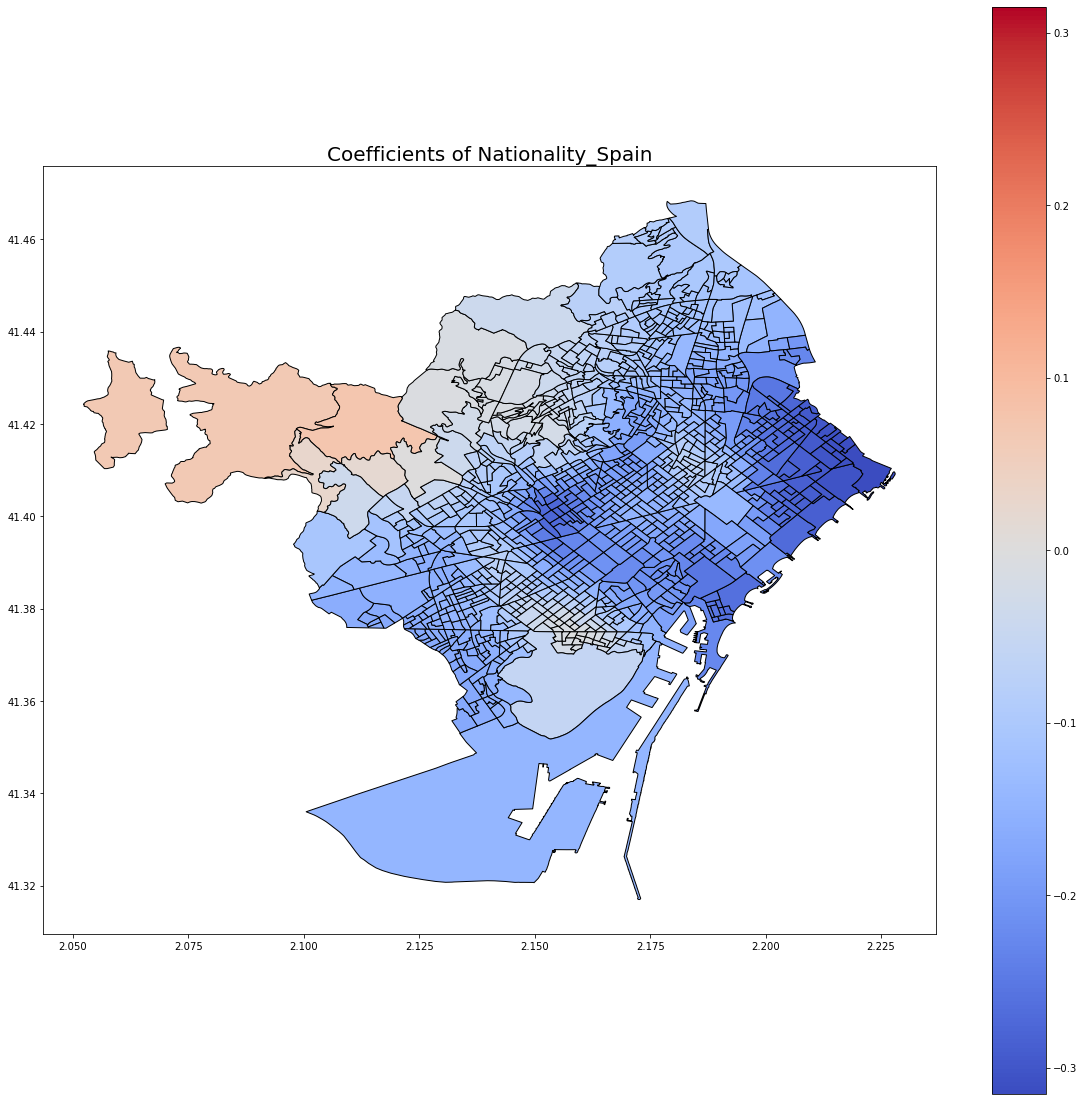

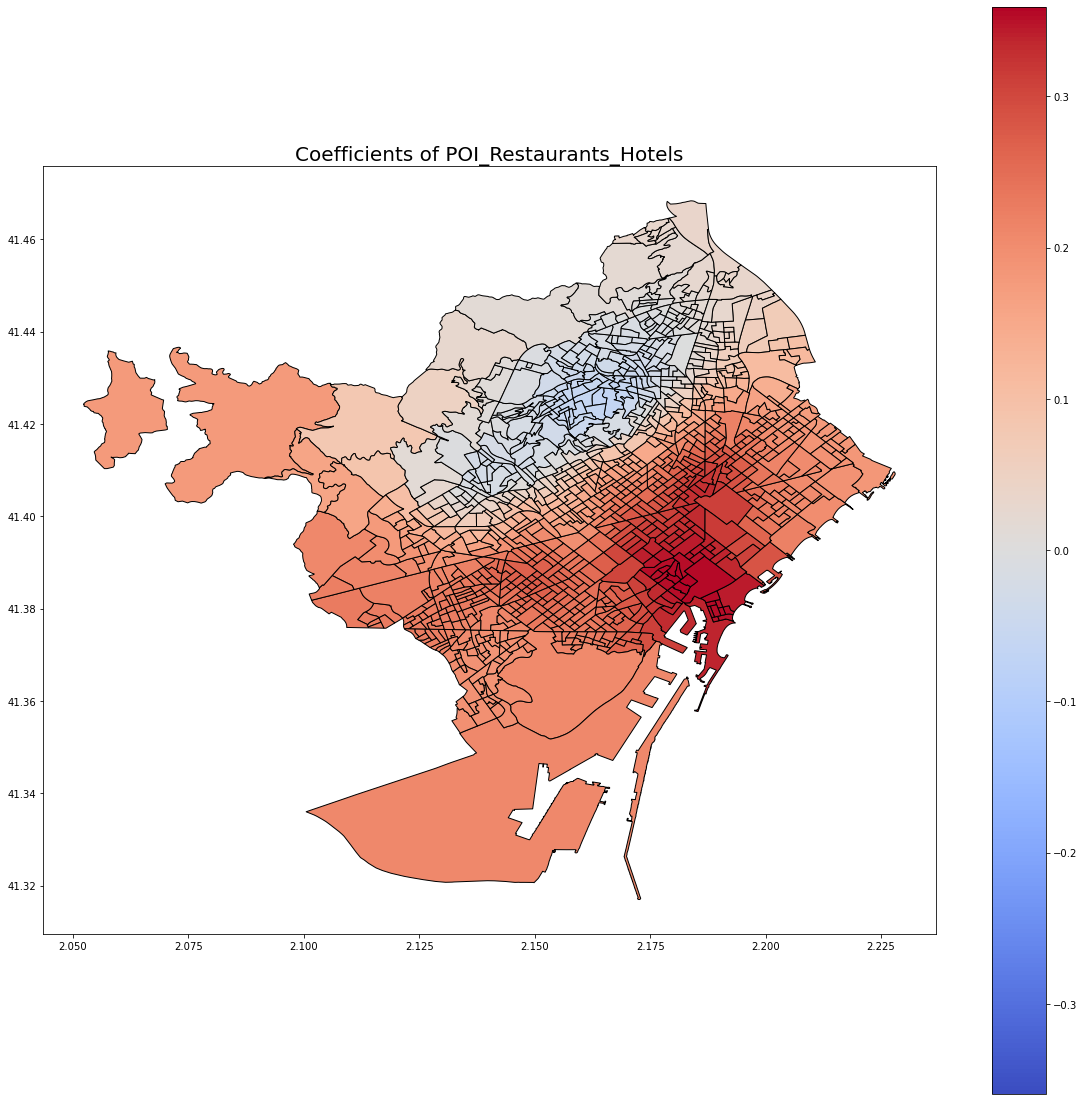

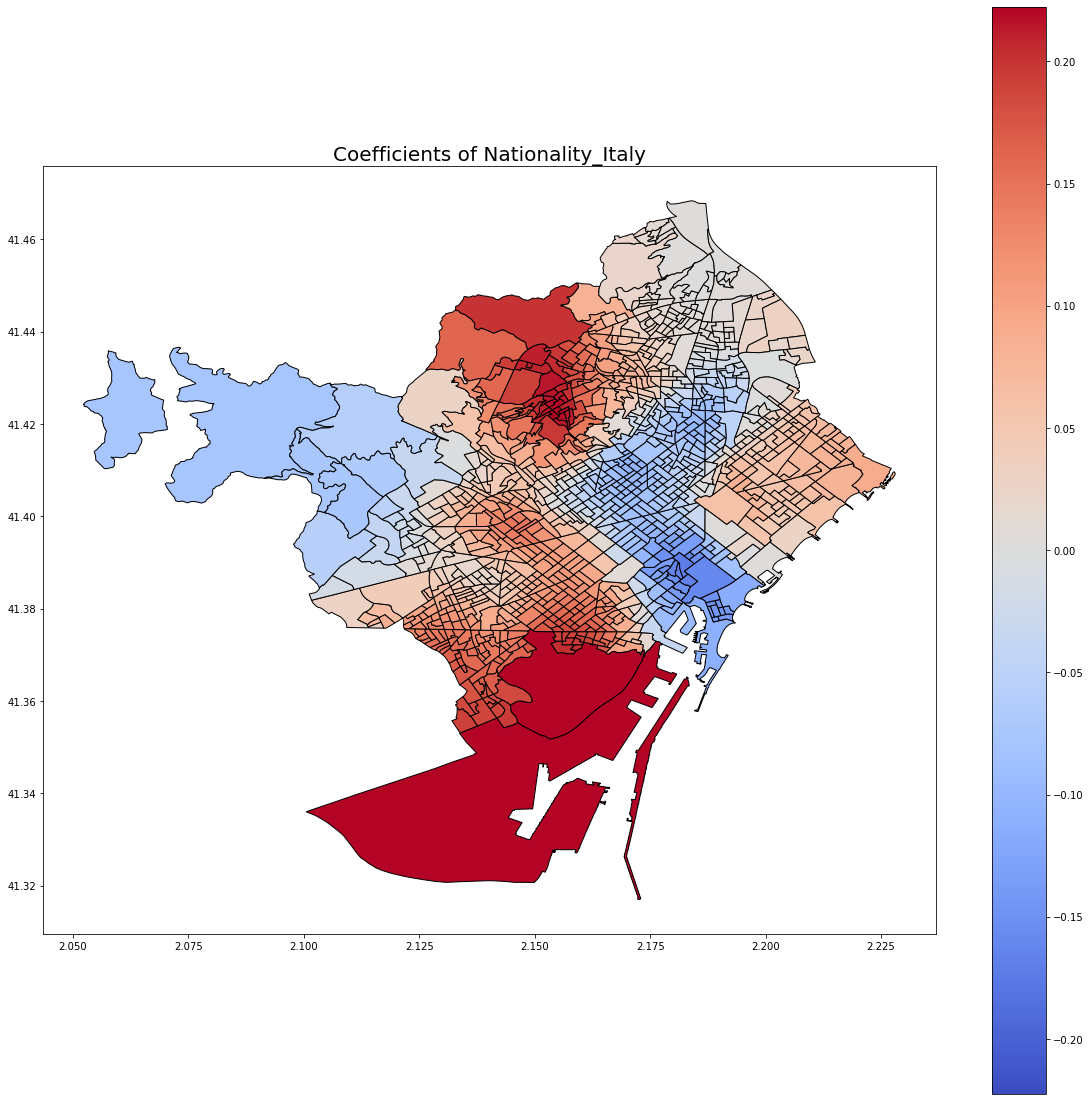

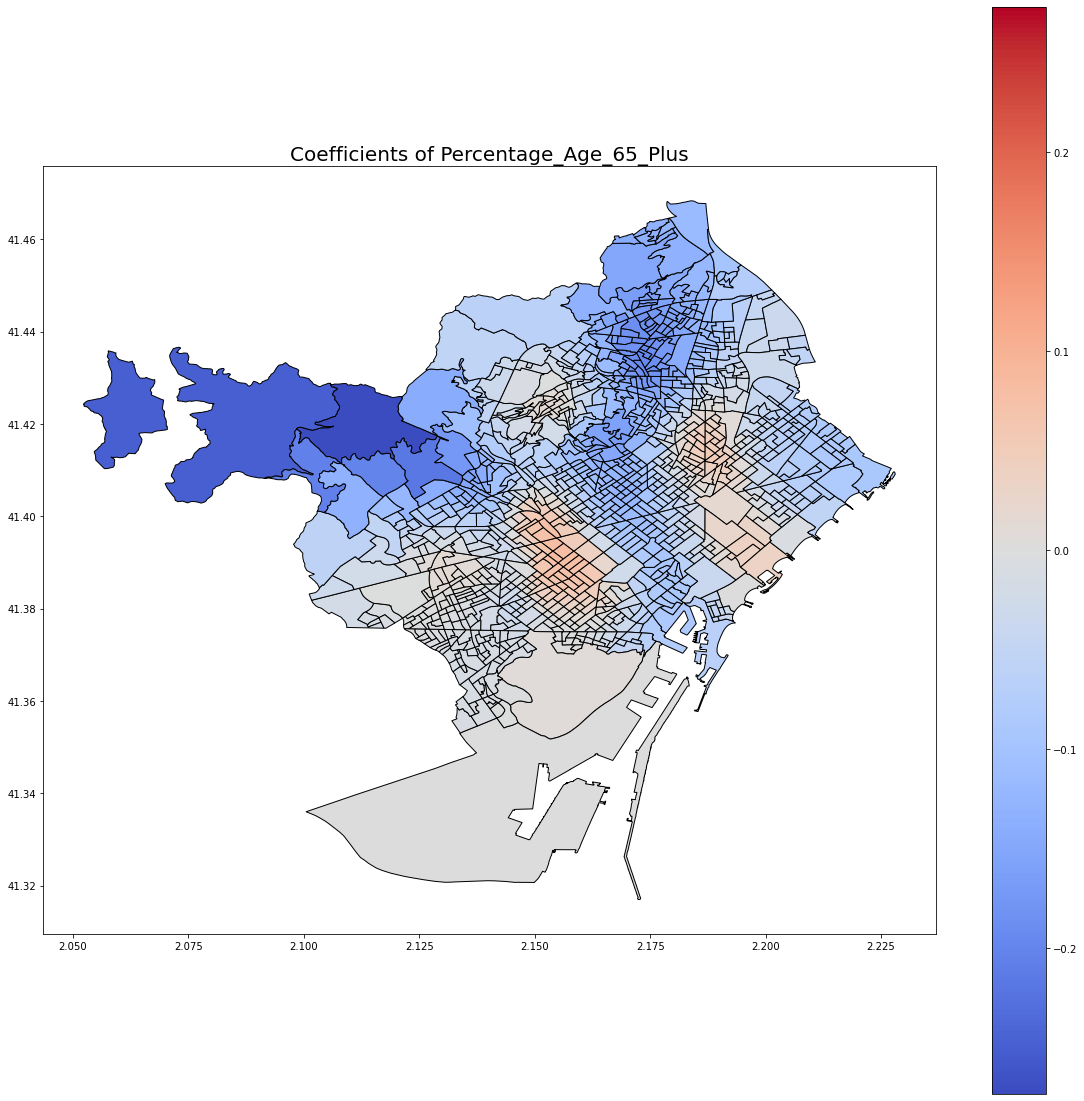

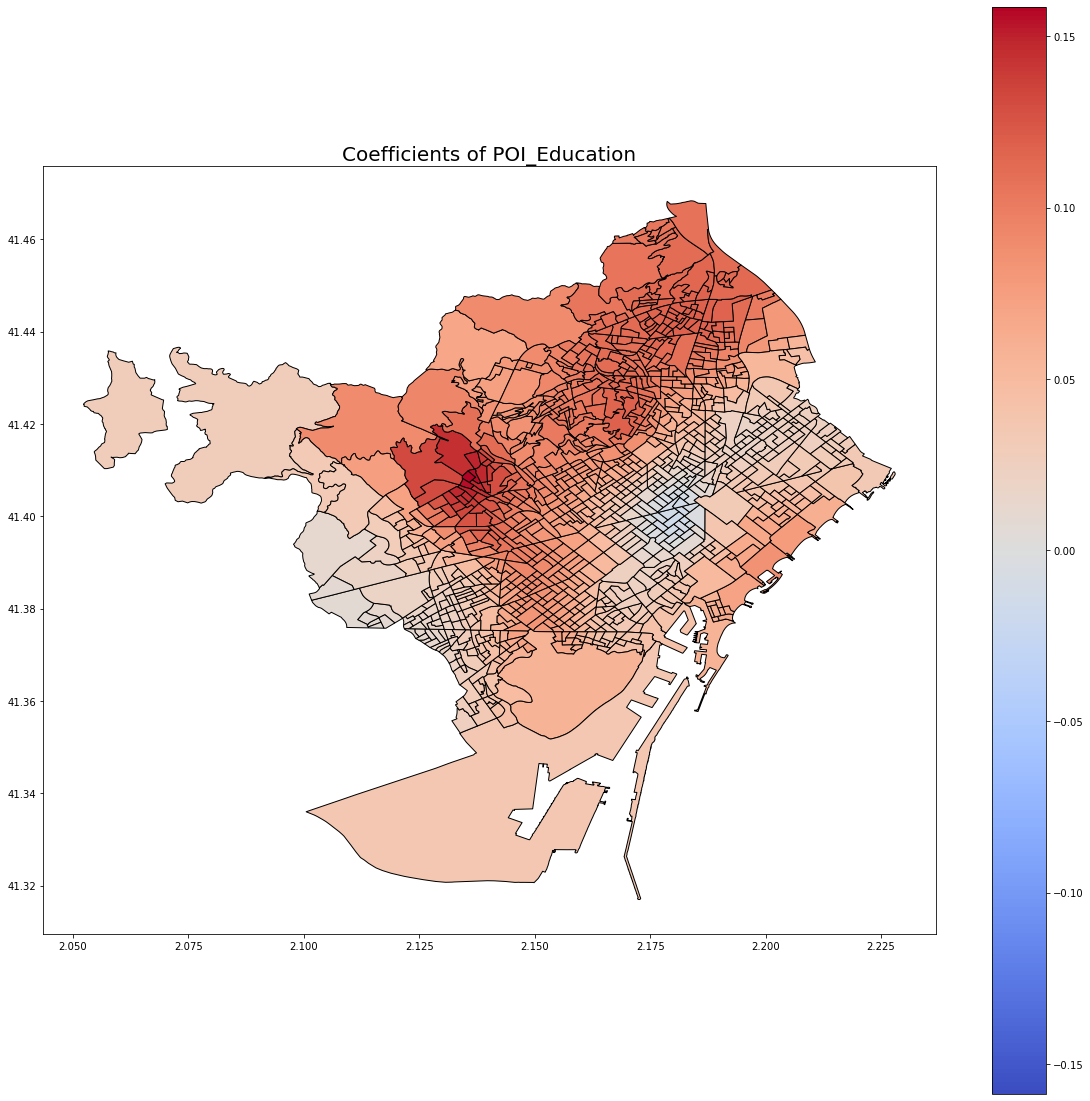

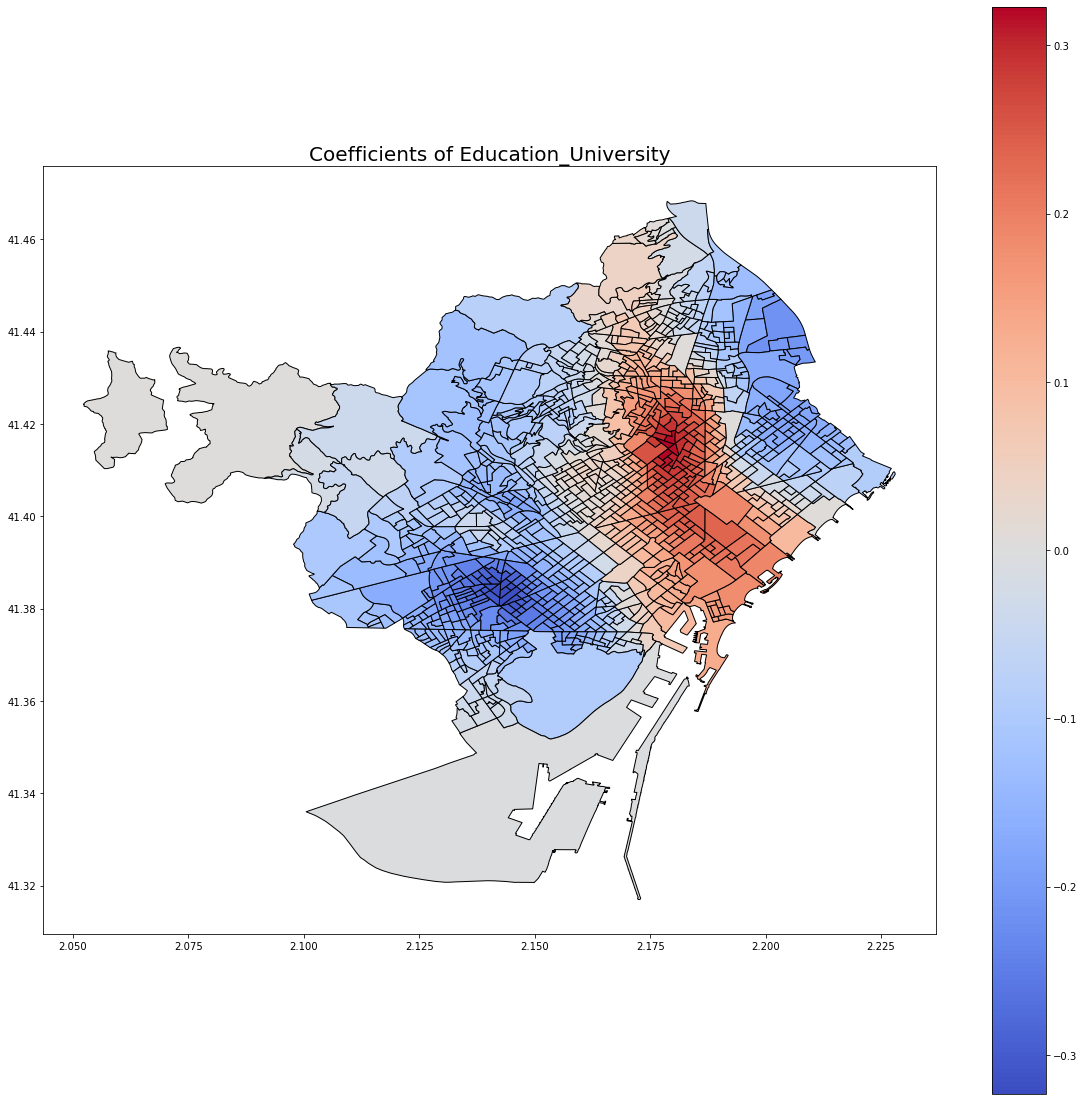

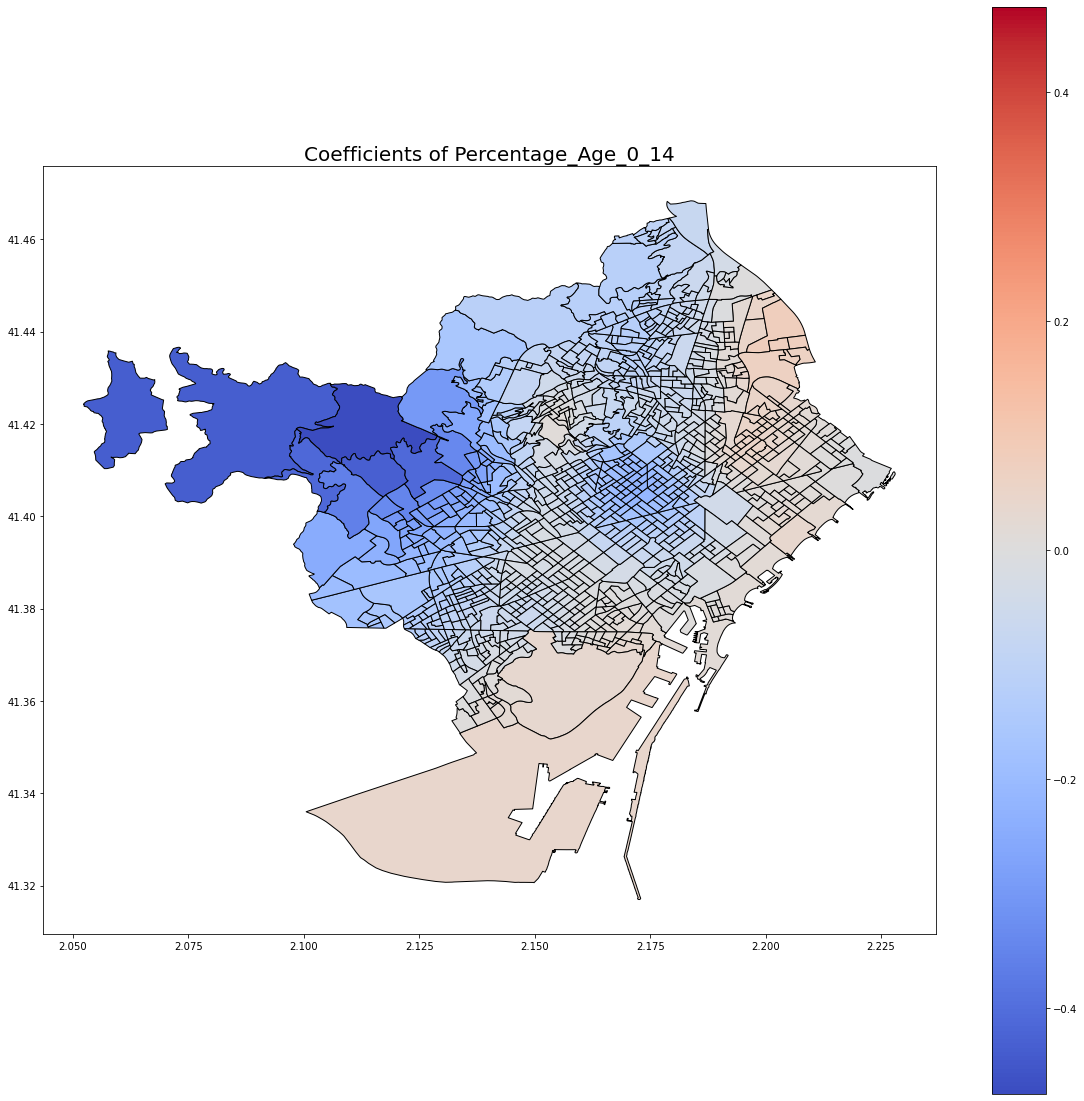

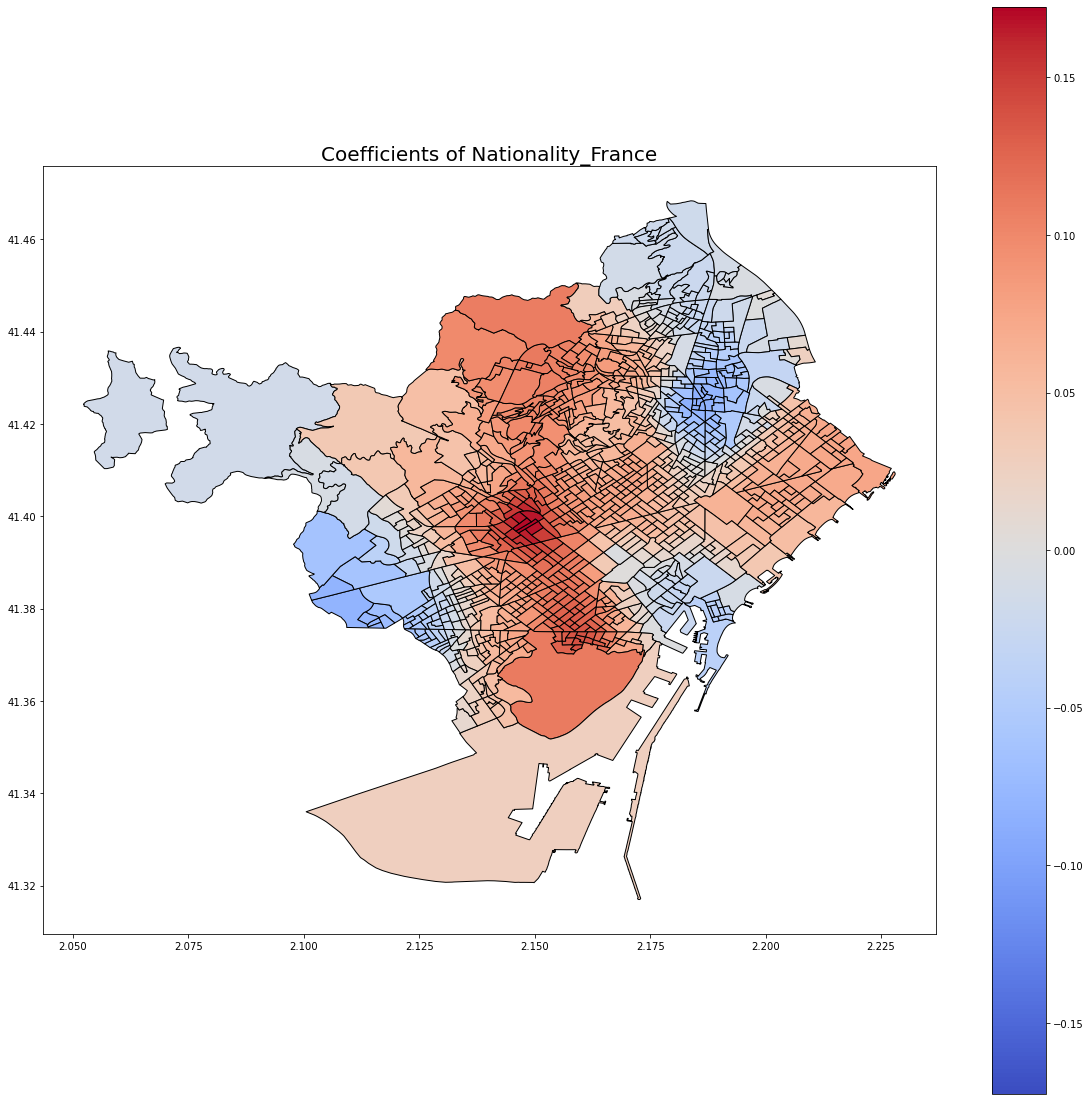

In [23]:
for col in coefs_chosen_gwr.columns:
    if col != "Intercept":
        fig, ax = plt.subplots(figsize=(20, 20))
        col_lim = max(abs(geo_info[col].min()), abs(geo_info[col].max()))
        geo_info.plot(
            ax=ax,
            edgecolor="black",
            column=col,
            legend=True,
            vmin=-col_lim,
            vmax=col_lim,
            cmap="coolwarm",
        )

        ax.set_title(
            "Coefficients of {}".format(col),
            fontsize=20,
        )
#         plt.savefig("coefs_{}.jpg".format(col))

In [24]:
geo_info["Chosen_Most_Important"] = (
    coefs_chosen_gwr.drop(["Intercept"], axis=1).abs().idxmax(axis=1).values
)

Text(0.5, 1.0, 'Most important coefficient per section')

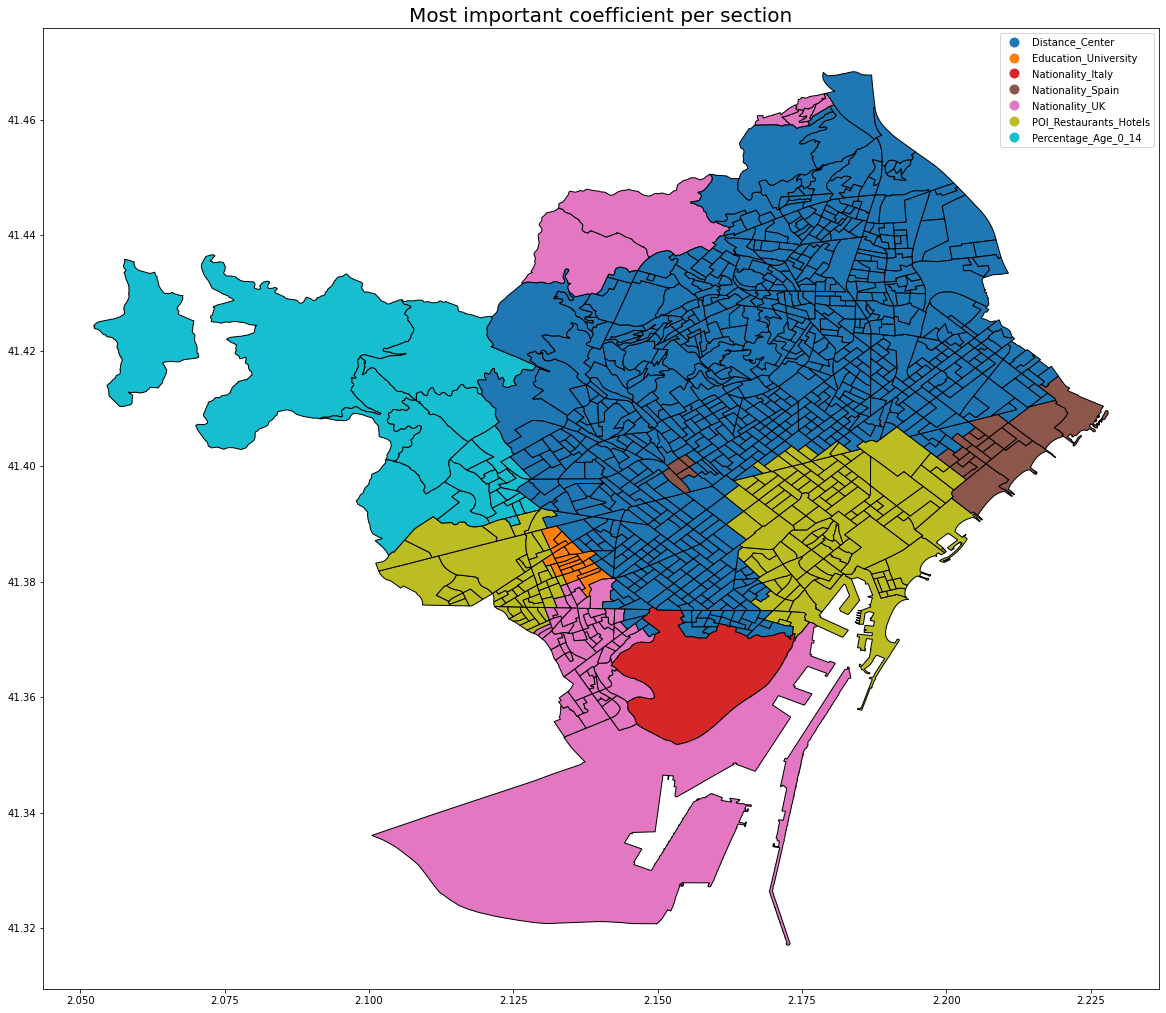

In [25]:
fig, ax = plt.subplots(figsize=(20, 20))
geo_info.plot(
    ax=ax,
    edgecolor="black",
    column="Chosen_Most_Important",
    legend=True,
)

ax.set_title(
    "Most important coefficient per section",
    fontsize=20,
)

# plt.savefig("important_coef.jpg")

# MGWR
All of the processes being modeled **DO NOT** operate at the same spatial scale